## Topic Modelling for Food Insecurity


## Table of Contents<a name="TOC"></a>

1. [Tokenize the cleaned tweets](#Section1)

2. [Create dictionary and tweet corpus](#Section2)

3. [Define no. of topics to try to build LDA model & compute coherence scor](#Section3)

4. [Train the final LDA model with best no. of topics](#Section4)

In [ ]:
pip install pyLDAvis

**Importing libraries & dataset**

In [1]:
#import libraries
import pandas as pd
import numpy as np
import gensim
from gensim import corpora, models, similarities
from gensim.models import LdaModel, CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from collections import OrderedDict
import seaborn as sns
# import pyLDAvis.gensim
import matplotlib.pyplot as plt

In [2]:
# Load the CLEANED tweets dataset (w/ Sentiment)
tweets_dataset = pd.read_csv(r"C:\Users\LENOVO\Documents\Degree Life\FYP Journey\Dataset\Sentiment Analysis\V3 Harmonized [VADER & TextBlob]_All Keywords (Whole Malaysia).csv")
display(tweets_dataset, len(tweets_dataset))

,Datetime,Username,Cleaned_Tweets,Location,VADER_score,TextBlob_score,Harmonized_Score,Harmonized_Label,Risk_Label
0,27/1/2023 14:32,Don Dale,buying forget review first guy feel want comme...,NaN,0.6703,-0.250000,0.210150,Positive,Low Risk
1,27/1/2023 19:04,Iliani,food security research going explode issue end...,NaN,0.5859,-0.181818,0.202041,Positive,Low Risk
2,29/1/2023 8:28,Naim Zaini,context slaughtered food muslim consideration ...,NaN,0.8658,0.034722,0.450261,Positive,Low Risk
3,29/1/2023 13:29,??,raise food price wet good expensive sorry guy,NaN,0.3818,-0.100000,0.140900,Positive,Low Risk
4,30/1/2023 21:52,Alinosourawr,che restaurant sek send food x order food drin...,NaN,-0.8934,-0.433333,-0.663367,Strongly Negative,Severe Risk
...,...,...,...,...,...,...,...,...,...
21832,2023-03-30 23:45:13+00:00,Charrlygirl,worried prosecution team family also worried f...,MA,-0.8360,0.000000,-0.418000,Mild Negative,Moderate Risk
21833,2023-03-30 23:49:23+00:00,angel19971102,love much clark must always worried bruce drea...,Taiwan,0.6939,0.400000,0.546950,Positive,Low Risk
21834,2023-03-30 23:55:01+00:00,firdyfire,industry player worried energy commission chie...,Malaysia,-0.0258,0.000000,-0.012900,Weakly Negative,Mild Risk
21835,2023-03-30 23:55:16+00:00,AhmadMuhyie,ah really weak faith fasting without real exam...,Jember,0.6222,0.239583,0.430892,Positive,Low Risk


21837

## 1. Tokenize the Cleaned Tweets<a name="Section1"></a>

In [3]:
from nltk.tokenize import word_tokenize

# Remove rows with missing values in 'Cleaned_Tweets' column
tokenized_tweets = tweets_dataset.dropna(subset=['Cleaned_Tweets'])

# Tokenize the tweets
tokenized_tweets['Tokenized_Tweets'] = tokenized_tweets['Cleaned_Tweets'].apply(lambda x: word_tokenize(str(x)))

# Display the 'Cleaned_Tweets' and 'Tokenized_Tweets' columns
display(tokenized_tweets[['Cleaned_Tweets', 'Tokenized_Tweets']])

,Cleaned_Tweets,Tokenized_Tweets
0,buying forget review first guy feel want comme...,"[buying, forget, review, first, guy, feel, wan..."
1,food security research going explode issue end...,"[food, security, research, going, explode, iss..."
2,context slaughtered food muslim consideration ...,"[context, slaughtered, food, muslim, considera..."
3,raise food price wet good expensive sorry guy,"[raise, food, price, wet, good, expensive, sor..."
4,che restaurant sek send food x order food drin...,"[che, restaurant, sek, send, food, x, order, f..."
...,...,...
21832,worried prosecution team family also worried f...,"[worried, prosecution, team, family, also, wor..."
21833,love much clark must always worried bruce drea...,"[love, much, clark, must, always, worried, bru..."
21834,industry player worried energy commission chie...,"[industry, player, worried, energy, commission..."
21835,ah really weak faith fasting without real exam...,"[ah, really, weak, faith, fasting, without, re..."


In [4]:
# Convert the 'Cleaned_Tweets' column to strings
tweets_dataset['Cleaned_Tweets'] = tweets_dataset['Cleaned_Tweets'].astype(str)

# Tokenize the cleaned tweets and store them in a new column 'Tokenized_Tweets'
tweets_dataset['Tokenized_Tweets'] = tweets_dataset['Cleaned_Tweets'].apply(word_tokenize)
display(tweets_dataset)

,Datetime,Username,Cleaned_Tweets,Location,VADER_score,TextBlob_score,Harmonized_Score,Harmonized_Label,Risk_Label,Tokenized_Tweets
0,27/1/2023 14:32,Don Dale,buying forget review first guy feel want comme...,NaN,0.6703,-0.250000,0.210150,Positive,Low Risk,"[buying, forget, review, first, guy, feel, wan..."
1,27/1/2023 19:04,Iliani,food security research going explode issue end...,NaN,0.5859,-0.181818,0.202041,Positive,Low Risk,"[food, security, research, going, explode, iss..."
2,29/1/2023 8:28,Naim Zaini,context slaughtered food muslim consideration ...,NaN,0.8658,0.034722,0.450261,Positive,Low Risk,"[context, slaughtered, food, muslim, considera..."
3,29/1/2023 13:29,??,raise food price wet good expensive sorry guy,NaN,0.3818,-0.100000,0.140900,Positive,Low Risk,"[raise, food, price, wet, good, expensive, sor..."
4,30/1/2023 21:52,Alinosourawr,che restaurant sek send food x order food drin...,NaN,-0.8934,-0.433333,-0.663367,Strongly Negative,Severe Risk,"[che, restaurant, sek, send, food, x, order, f..."
...,...,...,...,...,...,...,...,...,...,...
21832,2023-03-30 23:45:13+00:00,Charrlygirl,worried prosecution team family also worried f...,MA,-0.8360,0.000000,-0.418000,Mild Negative,Moderate Risk,"[worried, prosecution, team, family, also, wor..."
21833,2023-03-30 23:49:23+00:00,angel19971102,love much clark must always worried bruce drea...,Taiwan,0.6939,0.400000,0.546950,Positive,Low Risk,"[love, much, clark, must, always, worried, bru..."
21834,2023-03-30 23:55:01+00:00,firdyfire,industry player worried energy commission chie...,Malaysia,-0.0258,0.000000,-0.012900,Weakly Negative,Mild Risk,"[industry, player, worried, energy, commission..."
21835,2023-03-30 23:55:16+00:00,AhmadMuhyie,ah really weak faith fasting without real exam...,Jember,0.6222,0.239583,0.430892,Positive,Low Risk,"[ah, really, weak, faith, fasting, without, re..."


## 2. Create Dictionary and Tweet Corpus<a name="Section2"></a>

In [5]:
from gensim import corpora

# Create a dictionary from the tokenized tweets
dictionary = corpora.Dictionary(tweets_dataset['Tokenized_Tweets'])

# Create a corpus
tweet_corpus = [dictionary.doc2bow(tweet) for tweet in tweets_dataset['Tokenized_Tweets']]

#display tweet corpus
display(tweet_corpus)

[[(0, 2),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1)],
 [(2, 1),
  (6, 3),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 2),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 2)],
 [(4, 1),
  (6, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 2),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1)],
 [(2, 1), (6, 1), (8, 1), (40, 1), (44, 1), (45, 1), (46, 1), (47, 1)],
 [(2, 1),
  (6, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 2),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 2),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1)],
 [(2, 1),
  (6, 2),
  (16, 1),
  (55, 1),
  (71, 1),
  (72, 1),
  (73, 2),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 

## 3. Define No. of Topics to Try to Build LDA Model & Compute Coherence Score<a name="Section3"></a>

In [6]:
from gensim.models import CoherenceModel

# Define the number of topics you want to try (4 in this case)
num_topics_list = [4]

coherence_scores = []
for num_topics in num_topics_list:
    # Train the LDA model
    lda_model = models.LdaModel(corpus=tweet_corpus, id2word=dictionary, num_topics=num_topics, passes=10)

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=tweets_dataset['Tokenized_Tweets'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append((num_topics, coherence_score))
    
# Find the number of topics with the highest coherence score
best_num_topics = max(coherence_scores, key=lambda x: x[1])[0]
print(f"The optimal number of topics is: {best_num_topics}")

The optimal number of topics is: 4


## 4. Train the Final LDA model with Best No. of Topics<a name="Section4"></a>
<br>In this case, our defined no. of topics = 4</br>

In [7]:
# Train the final LDA model with the best number of topics
lda_model = models.LdaModel(corpus=tweet_corpus, id2word=dictionary, num_topics=best_num_topics, passes=10)

# Assign topics to each tweet in the dataset
topics_assigned = []
for tweet_bow in tweet_corpus:
    topic_distribution = lda_model.get_document_topics(tweet_bow)
    dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    topics_assigned.append(dominant_topic)

# Add the assigned topics to the tweets dataset
tweets_dataset['Assigned_Topic'] = topics_assigned

# Map the topic number to the corresponding topic name
topic_names = {
    0: 'Not enough food',
    1: 'Unaffordability',
    2: 'Difficulty in finding food',
    3: 'Food insecurity'
}
tweets_dataset['Topic_Name'] = tweets_dataset['Assigned_Topic'].map(topic_names)
display(tweets_dataset)

,Datetime,Username,Cleaned_Tweets,Location,VADER_score,TextBlob_score,Harmonized_Score,Harmonized_Label,Risk_Label,Tokenized_Tweets,Assigned_Topic,Topic_Name
0,27/1/2023 14:32,Don Dale,buying forget review first guy feel want comme...,NaN,0.6703,-0.250000,0.210150,Positive,Low Risk,"[buying, forget, review, first, guy, feel, wan...",2,Difficulty in finding food
1,27/1/2023 19:04,Iliani,food security research going explode issue end...,NaN,0.5859,-0.181818,0.202041,Positive,Low Risk,"[food, security, research, going, explode, iss...",0,Not enough food
2,29/1/2023 8:28,Naim Zaini,context slaughtered food muslim consideration ...,NaN,0.8658,0.034722,0.450261,Positive,Low Risk,"[context, slaughtered, food, muslim, considera...",0,Not enough food
3,29/1/2023 13:29,??,raise food price wet good expensive sorry guy,NaN,0.3818,-0.100000,0.140900,Positive,Low Risk,"[raise, food, price, wet, good, expensive, sor...",0,Not enough food
4,30/1/2023 21:52,Alinosourawr,che restaurant sek send food x order food drin...,NaN,-0.8934,-0.433333,-0.663367,Strongly Negative,Severe Risk,"[che, restaurant, sek, send, food, x, order, f...",1,Unaffordability
...,...,...,...,...,...,...,...,...,...,...,...,...
21832,2023-03-30 23:45:13+00:00,Charrlygirl,worried prosecution team family also worried f...,MA,-0.8360,0.000000,-0.418000,Mild Negative,Moderate Risk,"[worried, prosecution, team, family, also, wor...",3,Food insecurity
21833,2023-03-30 23:49:23+00:00,angel19971102,love much clark must always worried bruce drea...,Taiwan,0.6939,0.400000,0.546950,Positive,Low Risk,"[love, much, clark, must, always, worried, bru...",3,Food insecurity
21834,2023-03-30 23:55:01+00:00,firdyfire,industry player worried energy commission chie...,Malaysia,-0.0258,0.000000,-0.012900,Weakly Negative,Mild Risk,"[industry, player, worried, energy, commission...",0,Not enough food
21835,2023-03-30 23:55:16+00:00,AhmadMuhyie,ah really weak faith fasting without real exam...,Jember,0.6222,0.239583,0.430892,Positive,Low Risk,"[ah, really, weak, faith, fasting, without, re...",2,Difficulty in finding food


In [ ]:
lda_model.print_topics()

In [ ]:
lda_model.show_topics()

In [8]:
# Count the number of tweets for each topic
topic_counts = tweets_dataset['Topic_Name'].value_counts().reset_index()
topic_counts.columns = ['Topic_Name', 'Tweet_Count']

# Display the number of tweets per topic
print("Number of tweets per topic:")
display(topic_counts)

Number of tweets per topic:


,Topic_Name,Tweet_Count
0,Unaffordability,8881
1,Difficulty in finding food,5283
2,Not enough food,4003
3,Food insecurity,3670


Number of tweets per topic:


,Topic_Name,Tweet_Count
0,Unaffordability,8881
1,Difficulty in finding food,5283
2,Not enough food,4003
3,Food insecurity,3670


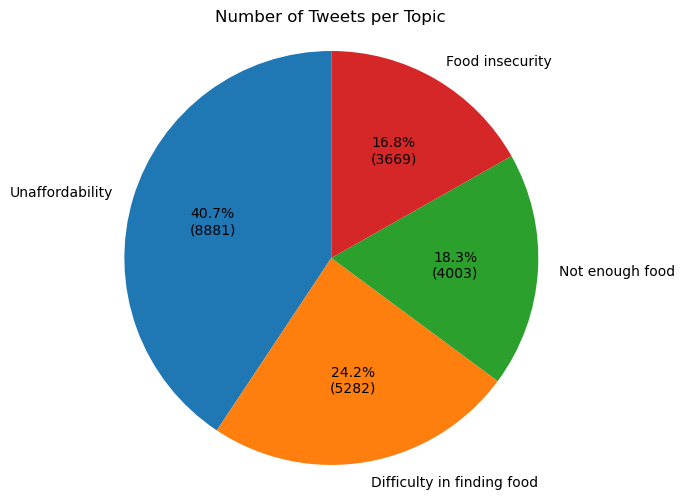

In [21]:
import matplotlib.pyplot as plt

# Count the number of tweets for each topic
topic_counts = tweets_dataset['Topic_Name'].value_counts().reset_index()
topic_counts.columns = ['Topic_Name', 'Tweet_Count']

# Display the number of tweets per topic
print("Number of tweets per topic:")
display(topic_counts)

# Plot a pie chart for the tweet counts
plt.figure(figsize=(8, 6))
plt.pie(
    topic_counts['Tweet_Count'],
    labels=topic_counts['Topic_Name'],
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*sum(topic_counts['Tweet_Count']))})",
    startangle=90
)
plt.title("Number of Tweets per Topic")
plt.axis('equal')

# Show the pie chart
plt.show()

In [9]:
#Visualize topic distribution
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Convert the gensim LDA model to a format compatible with pyLDAvis
vis_data = gensimvis.prepare(lda_model, tweet_corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis_data)

In [15]:
# Print the top 30 words for each topic
num_words = 30
for topic_id in range(best_num_topics):
    topic_words = lda_model.show_topic(topic_id, topn=num_words)
    topic_words = [word for word, _ in topic_words]
    print(f"Topic {topic_id + 1}:")
    print(', '.join(topic_words))
    print()

Topic 1:
food, price, people, expensive, good, buy, cheap, money, help, many, starving, rm, country, cost, want, government, year, rise, bazaar, rising, also, poor, pay, one, say, family, need, due, make, starve

Topic 2:
hungry, eat, want, eating, stomach, time, rice, night, morning, hour, day, today, food, back, full, know, chicken, cook, home, sleep, feel, sleepy, last, first, lunch, breakfast, clock, order, tired, meal

Topic 3:
hungry, fasting, hunger, worried, thirst, fast, day, feel, get, not, can, time, people, make, know, month, take, thirsty, thing, always, love, food, eat, ramadan, never, also, good, one, hold, really

Topic 4:
worried, hunger, game, holding, world, one, really, people, would, allah, god, know, get, got, could, life, said, may, day, thank, nothing, love, hope, power, think, well, na, see, made, right



<h3>Create word cloud for each topic</h3>

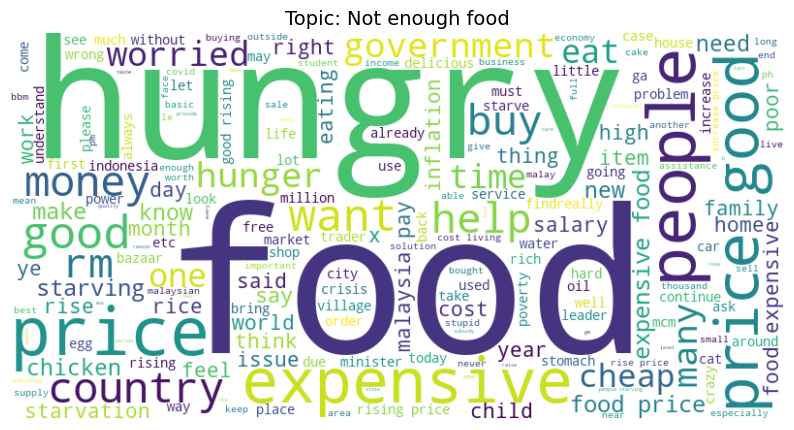

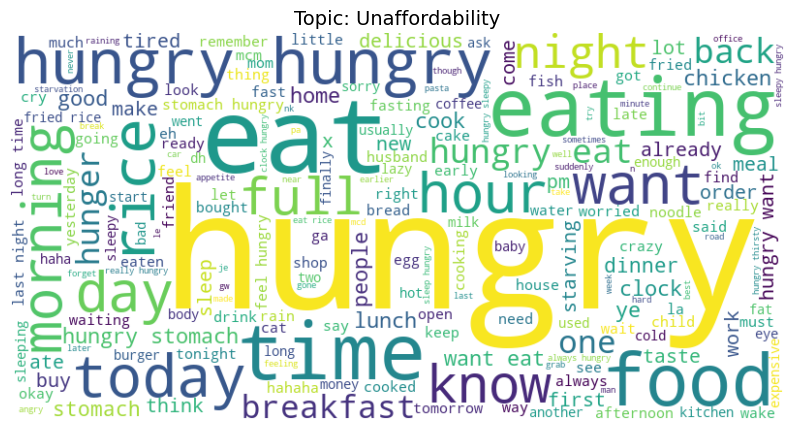

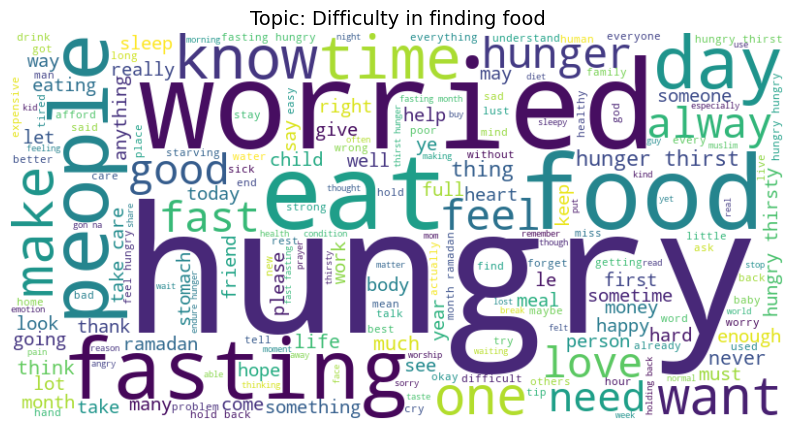

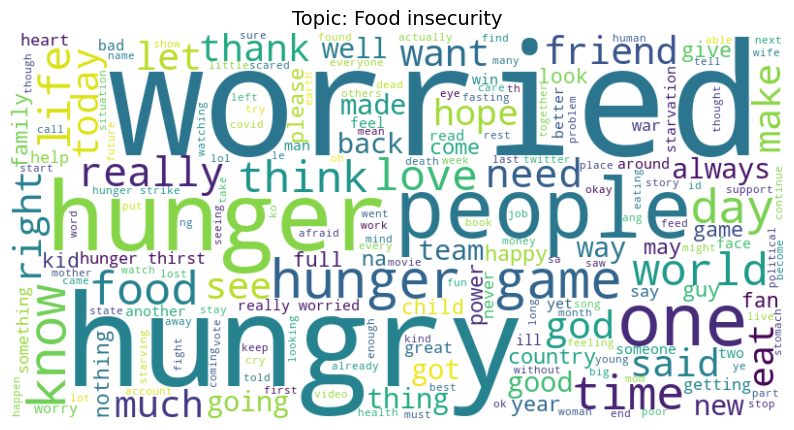

In [16]:
from wordcloud import WordCloud

# Create word clouds for each topic
for topic_id in topic_names.keys():
    # Get the tweets corresponding to the topic
    topic_tweets = tweets_dataset[tweets_dataset['Assigned_Topic'] == topic_id]['Tokenized_Tweets']
    # Concatenate the tokens into a single string
    topic_words = ' '.join(topic_tweets.sum())
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_words)
    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic: {topic_names[topic_id]}', fontsize=14)
    plt.axis('off')
    plt.show()

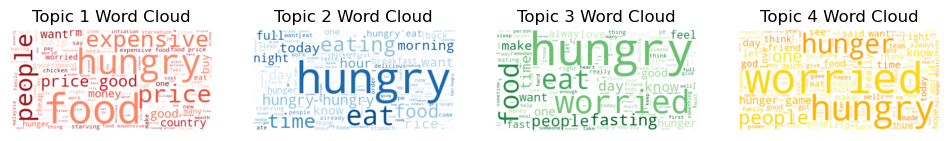

In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Define the color map for each topic
color_map = {
    0: 'Reds',
    1: 'Blues',
    2: 'Greens',
    3: 'Wistia'
}

# Create subplots for each topic
fig, axs = plt.subplots(1, best_num_topics, figsize=(12, 6))

# Generate word clouds for each topic
for topic_id in range(best_num_topics):
    # Filter the tweets for the current topic
    topic_tweets = tweets_dataset[tweets_dataset['Assigned_Topic'] == topic_id]

    # Concatenate all tokenized tweets for the current topic
    topic_tokens = ' '.join([token for tweet_tokens in topic_tweets['Tokenized_Tweets'] for token in tweet_tokens])

    # Generate a word cloud for the current topic
    wordcloud = WordCloud(background_color='white', colormap=color_map[topic_id]).generate(topic_tokens)

    # Plot the word cloud in the corresponding subplot
    axs[topic_id].imshow(wordcloud, interpolation='bilinear')
    axs[topic_id].set_title(f"Topic {topic_id + 1} Word Cloud")
    axs[topic_id].axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the subplots
plt.show()

**Save topic modelling results into CSV file**

In [ ]:
#Save the VADER sentiment dataset
tweets_dataset.to_csv('[FINAL UPDATED] TextBlob_All Keywords - Overall (Malaysia & States) w/ Topic Modelling - Snscrape.csv', index=False)

**Extracting Top 20 Keywords from the Dataset**

In [1]:
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
# Load csv file containing tweets dataset (w/ sentiments)

tweets_df = pd.read_csv(r"C:\Users\LENOVO\Documents\Degree Life\FYP Journey\Dataset\Sentiment Analysis\V3 Harmonized [VADER & TextBlob]_All Keywords (Whole Malaysia).csv")
display(tweets_df)

,Datetime,Username,Cleaned_Tweets,Location,VADER_score,TextBlob_score,Harmonized_Score,Harmonized_Label,Risk_Label
0,27/1/2023 14:32,Don Dale,buying forget review first guy feel want comme...,Malaysia,0.6703,-0.250000,0.210150,Positive,Low Risk
1,27/1/2023 19:04,Iliani,food security research going explode issue end...,Malaysia,0.5859,-0.181818,0.202041,Positive,Low Risk
2,29/1/2023 8:28,Naim Zaini,context slaughtered food muslim consideration ...,Malaysia,0.8658,0.034722,0.450261,Positive,Low Risk
3,29/1/2023 13:29,??,raise food price wet good expensive sorry guy,Malaysia,0.3818,-0.100000,0.140900,Positive,Low Risk
4,30/1/2023 21:52,Alinosourawr,che restaurant sek send food x order food drin...,Malaysia,-0.8934,-0.433333,-0.663367,Strongly Negative,Severe Risk
...,...,...,...,...,...,...,...,...,...
21832,2023-03-30 23:45:13+00:00,Charrlygirl,worried prosecution team family also worried f...,Malaysia,-0.8360,0.000000,-0.418000,Mild Negative,Moderate Risk
21833,2023-03-30 23:49:23+00:00,angel19971102,love much clark must always worried bruce drea...,Malaysia,0.6939,0.400000,0.546950,Positive,Low Risk
21834,2023-03-30 23:55:01+00:00,firdyfire,industry player worried energy commission chie...,Malaysia,-0.0258,0.000000,-0.012900,Weakly Negative,Mild Risk
21835,2023-03-30 23:55:16+00:00,AhmadMuhyie,ah really weak faith fasting without real exam...,Malaysia,0.6222,0.239583,0.430892,Positive,Low Risk


In [4]:
# Assuming df is your DataFrame and 'Cleaned Tweets' is your column of interest
words = ' '.join(tweets_df['Cleaned_Tweets']).lower().split()
words = [word for word in words if word not in stopwords.words('english')]

# Count the frequency of each word
word_freq = Counter(words)

# Create a DataFrame from the dictionary
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index').reset_index()
word_freq_df.columns = ['Keyword', 'Frequency']

# Get top 20 words
top_20_words = word_freq_df.sort_values(by='Frequency', ascending=False).head(20)

In [5]:
display(top_20_words)

,Keyword,Frequency
156,hungry,12905
10,food,3345
318,eat,3096
798,worried,2836
187,hunger,2261
43,people,1952
27,price,1906
46,good,1876
125,time,1757
6,want,1733


In [6]:
#Save results into CSV file
top_20_words.to_csv('Top 20 Keywords SA FI Risk.csv', index=False)

In [ ]:
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load csv file containing tweets dataset (w/ sentiments)

tweets_df = pd.read_csv(r"C:\Users\LENOVO\Documents\Degree Life\FYP Journey\Dataset\Sentiment Analysis\V3 Harmonized [VADER & TextBlob]_All Keywords (Whole Malaysia).csv")
display(tweets_df)

# Assuming df is your DataFrame and 'Cleaned Tweets' is your column of interest
words = ' '.join(tweets_df['Cleaned_Tweets']).lower().split()
words = [word for word in words if word not in stopwords.words('english')]

# Count the frequency of each word
word_freq = Counter(words)

# Create a DataFrame from the dictionary
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index').reset_index()
word_freq_df.columns = ['Keyword', 'Frequency']

# Get top 20 words
top_20_words = word_freq_df.sort_values(by='Frequency', ascending=False).head(20)

display(top_20_words)

#Save results into CSV file
top_20_words.to_csv('Top 20 Keywords SA FI Risk.csv', index=False)